# Smaller Fractions & Deeper K Analysis

This notebook fetches runs from wandb tagged with `e21TG_smaller_fracions_deeper_k` and creates transferability plots.


In [1]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Initialize wandb API
api = wandb.Api()


## Fetch Runs from Wandb by Tag


In [5]:
def fetch_runs_by_tag(entity: str, project: str, tag: str) -> pd.DataFrame:
    """
    Fetch running and finished runs from a wandb project filtered by tag.
    
    Args:
        entity: wandb entity (user or team)
        project: wandb project name
        tag: wandb tag to filter runs
    
    Returns:
        DataFrame with run information
    """
    # Fetch running and finished runs with the specified tag
    filters = {
        "$and": [
            {"$or": [{"state": "running"}, {"state": "finished"}]},
            {"tags": {"$in": [tag]}}
        ]
    }
    runs = api.runs(f"{entity}/{project}", filters=filters)
    
    records = []
    for run in runs:
        # Get summary metrics
        summary = run.summary._json_dict
        config = run.config
        
        # Get normalized_abs_error (might be named normalized_abs_err in some runs)
        normalized_abs_error = summary.get('normalized_abs_error') or summary.get('normalized_abs_err', 0)
        
        # Skip runs with zero/missing normalized_abs_error
        if not normalized_abs_error or normalized_abs_error == 0:
            continue
        
        # Extract resolution from dataset_name or train_data
        dataset_name = config.get('dataset_name', '')
        train_data = config.get('train_data', '')
        
        # Try to extract resolution number (e.g., res17 -> 17)
        res_match = re.search(r'res(\d+)', dataset_name) or re.search(r'res(\d+)', train_data)
        if res_match:
            resolution = int(res_match.group(1))
        else:
            # Skip runs without resolution info
            continue
        
        records.append({
            'run_id': run.id,
            'run_name': run.name,
            'state': run.state,
            'resolution': resolution,
            'train_density': resolution,
            'normalized_abs_error': normalized_abs_error,
            'layer_type': config.get('layer_type', 'Unknown'),
            'k_hops': config.get('k_hops', config.get('k', None)),  # Extract k parameter
            'epochs': config.get('epochs', 0),
            'learning_rate': config.get('learning_rate', 0),
            'dataset_name': dataset_name,
            'tags': run.tags,
        })
    
    return pd.DataFrame(records)


# Fetch runs with the specified tag
TAG = "e21TG_smaller_fracions_deeper_k"
print(f"Fetching runs with tag: {TAG}")

# Try both entities in case runs are in different projects
df_jotaporras = fetch_runs_by_tag('alelab', 'terrains', TAG)
df_alelab = fetch_runs_by_tag('alelab', 'terrains', TAG)

df = pd.concat([df_jotaporras, df_alelab], ignore_index=True).drop_duplicates(subset='run_id')
print(f"Found {len(df)} valid runs")


Fetching runs with tag: e21TG_smaller_fracions_deeper_k
Found 80 valid runs


In [7]:
df.head()

,run_id,run_name,state,resolution,train_density,normalized_abs_error,layer_type,k_hops,epochs,learning_rate,dataset_name,tags
0,hex4n0n9,terrain-graph-TAGConv-res23-stage1,finished,23,23,0.022982,TAGConv,None,500,0.0001,norway/res23,"[TAGConv, e21TG_smaller_fracions_deeper_k, sta..."
1,vv5c0pk4,terrain-graph-TAGConv-res24-stage1,finished,24,24,0.022641,TAGConv,None,500,0.0001,norway/res24,"[TAGConv, e21TG_smaller_fracions_deeper_k, sta..."
2,aa3dp8h9,terrain-graph-TAGConv-res21-stage1,finished,21,21,0.025595,TAGConv,None,500,0.0001,norway/res21,"[TAGConv, e21TG_smaller_fracions_deeper_k, sta..."
3,rvclqcw3,terrain-graph-TAGConv-res22-stage1,finished,22,22,0.023440,TAGConv,None,500,0.0001,norway/res22,"[TAGConv, e21TG_smaller_fracions_deeper_k, sta..."
4,3vh4c9hv,terrain-graph-TAGConv-res24_phase2-stage2,finished,24,24,0.005528,TAGConv,None,250,0.0010,res24_phase2,"[TAGConv, e21TG_smaller_fracions_deeper_k, sta..."


In [8]:
# Add density column (inverse of resolution squared)
df['density'] = 1 / (df['resolution'] ** 2)

print(f"Total runs: {len(df)}")
print(f"\nRuns by layer type:")
print(df['layer_type'].value_counts())
print(f"\nK-hops values:")
print(df['k_hops'].value_counts())
print(f"\nResolutions available:")
print(sorted(df['resolution'].unique()))


Total runs: 80

Runs by layer type:
layer_type
TAGConv     40
SparseGT    40
Name: count, dtype: int64

K-hops values:
Series([], Name: count, dtype: int64)

Resolutions available:
[np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40)]


In [9]:
# Extract stage from dataset_name
def extract_stage(row):
    dataset_name = row['dataset_name']
    
    if 'norway/' in dataset_name:
        return 1
    match = re.search(r'_phase(\d+)', dataset_name)
    if match:
        return int(match.group(1))
    return None

df['stage'] = df.apply(extract_stage, axis=1)

print("Stage distribution:")
print(df.groupby(['layer_type', 'stage']).size())


Stage distribution:
layer_type  stage
SparseGT    1        20
            2        20
TAGConv     1        20
            2        20
dtype: int64


In [10]:
# Compute Accuracy Proxy from Normalized Absolute Error
df['accuracy_proxy'] = (1 - df['normalized_abs_error'].clip(upper=1)) * 100

print("Sample data:")
df[['run_name', 'resolution', 'density', 'k_hops', 'stage', 'normalized_abs_error']].head(10)


Sample data:


,run_name,resolution,density,k_hops,stage,normalized_abs_error
0,terrain-graph-TAGConv-res23-stage1,23,0.001890,None,1,0.022982
1,terrain-graph-TAGConv-res24-stage1,24,0.001736,None,1,0.022641
2,terrain-graph-TAGConv-res21-stage1,21,0.002268,None,1,0.025595
3,terrain-graph-TAGConv-res22-stage1,22,0.002066,None,1,0.023440
4,terrain-graph-TAGConv-res24_phase2-stage2,24,0.001736,None,2,0.005528
5,terrain-graph-TAGConv-res23_phase2-stage2,23,0.001890,None,2,0.006965
6,terrain-graph-TAGConv-res22_phase2-stage2,22,0.002066,None,2,0.006624
7,terrain-graph-TAGConv-res21_phase2-stage2,21,0.002268,None,2,0.008755
8,terrain-graph-SparseGT-res24-stage1,24,0.001736,None,1,0.020982
9,terrain-graph-SparseGT-res23-stage1,23,0.001890,None,1,0.019957


In [11]:
df.sort_values('resolution', ascending=False)[['run_name', 'resolution', 'density', 'k_hops', 'stage', 'normalized_abs_error']]

,run_name,resolution,density,k_hops,stage,normalized_abs_error
79,terrain-graph-SparseGT-res40_phase2-stage2,40,0.000625,None,2,0.004355
75,terrain-graph-SparseGT-res40-stage1,40,0.000625,None,1,0.021278
74,terrain-graph-TAGConv-res40_phase2-stage2,40,0.000625,None,2,0.006788
72,terrain-graph-TAGConv-res40-stage1,40,0.000625,None,1,0.024465
78,terrain-graph-SparseGT-res39_phase2-stage2,39,0.000657,None,2,0.007946
...,...,...,...,...,...,...
3,terrain-graph-TAGConv-res22-stage1,22,0.002066,None,1,0.023440
13,terrain-graph-SparseGT-res21_phase2-stage2,21,0.002268,None,2,0.004727
11,terrain-graph-SparseGT-res21-stage1,21,0.002268,None,1,0.026054
7,terrain-graph-TAGConv-res21_phase2-stage2,21,0.002268,None,2,0.008755


In [12]:
df[df.stage==2.0].groupby(['model_type','resolution'])['normalized_abs_error'].mean().reset_index().query('model_type=="Sparse GT"')

KeyError: 'model_type'

## Transferability Plot


Using 40 stage 2 runs (filtered from 80 total)


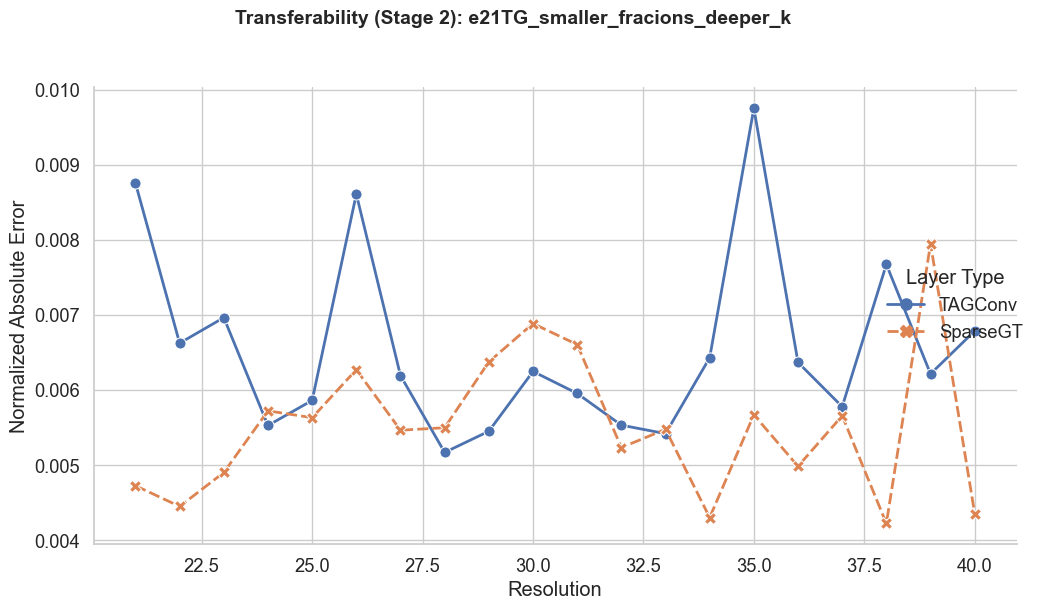

In [13]:
# Set plot style
sns.set_theme(style="whitegrid", font_scale=1.2)

# Filter to stage 2 only
df_stage2 = df[df['stage'] == 2]
print(f"Using {len(df_stage2)} stage 2 runs (filtered from {len(df)} total)")

# Create transferability plot - colored by k_hops if available
hue_col = 'k_hops' if df_stage2['k_hops'].notna().any() else 'layer_type'

g = sns.relplot(
    data=df_stage2,
    x='resolution',
    y='normalized_abs_error',
    hue=hue_col,
    kind='line',
    markers=True,
    style=hue_col,
    height=6,
    aspect=1.5,
    errorbar=None,
    markersize=8,
    linewidth=2,
)

g.set_axis_labels("Resolution", "Normalized Absolute Error")
g.legend.set_title(hue_col.replace('_', ' ').title())
g.fig.suptitle(f"Transferability (Stage 2): {TAG}", y=1.02, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('e21_smaller_fractions_transferability.png', dpi=150, bbox_inches='tight')
plt.show()


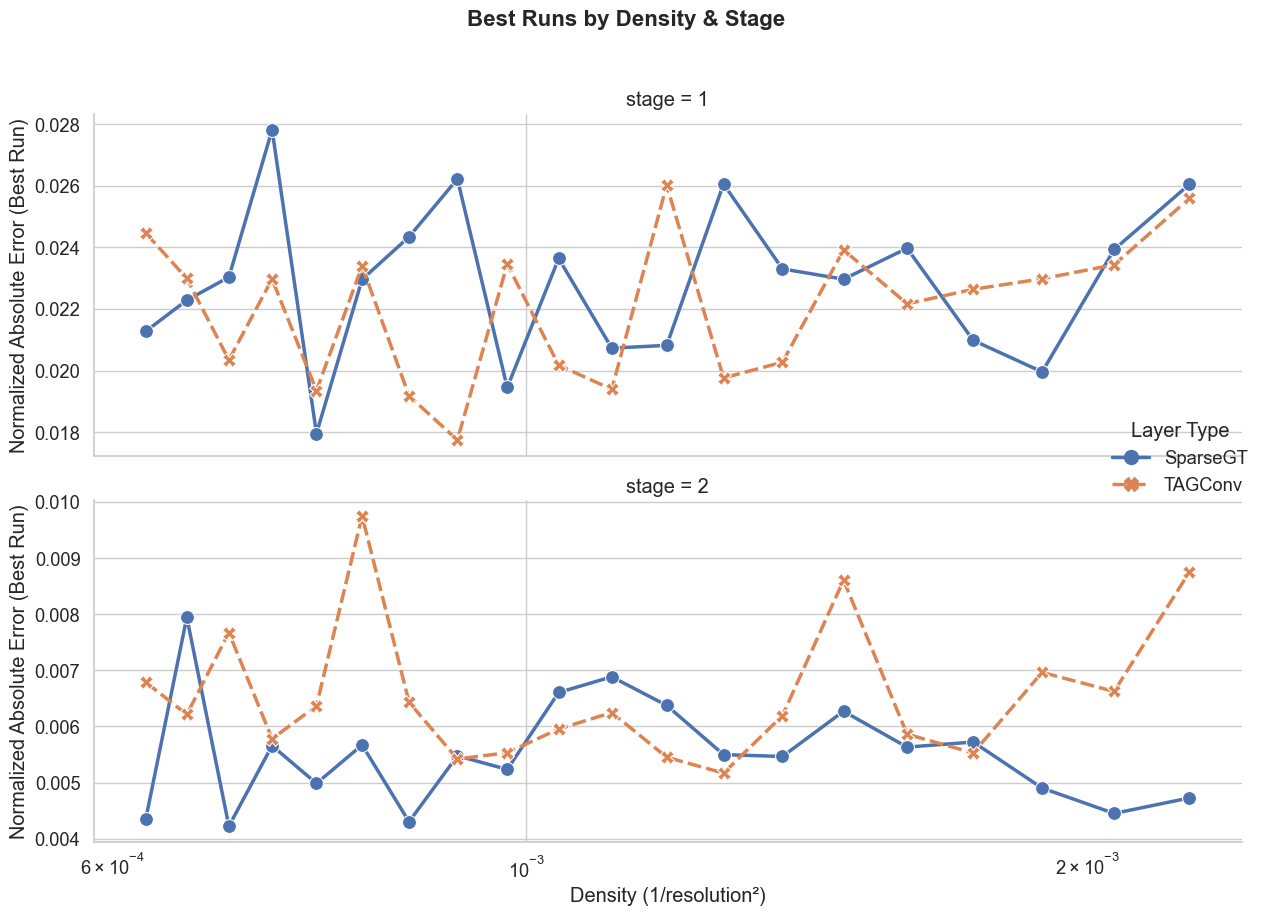

In [14]:
# Best performance per density per k_hops/layer_type and stage
if df['stage'].notna().any():
    best_per_density = df.loc[df.groupby([hue_col, 'density', 'stage'])['normalized_abs_error'].idxmin()]

    g2 = sns.relplot(
        data=best_per_density,
        x='density',
        y='normalized_abs_error',
        hue=hue_col,
        kind='line',
        markers=True,
        style=hue_col,
        row="stage",
        height=4.5,
        aspect=2.5,
        markersize=10,
        linewidth=2.5,
        facet_kws=dict(sharex=True, sharey=False),
    )

    g2.set_axis_labels("Density (1/resolution²)", "Normalized Absolute Error (Best Run)")
    g2.legend.set_title(hue_col.replace('_', ' ').title())
    g2.fig.suptitle("Best Runs by Density & Stage", y=1.02, fontsize=16, fontweight='bold')
    g2.set(xscale='log')
    plt.tight_layout()
    plt.savefig('e21_smaller_fractions_best.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No stage information available")


In [15]:
# Find stage 2 runs at resolution 40
res40_stage2 = df[(df['resolution'] == 40) & (df['stage'] == 2)]
print(f"Stage 2 runs at resolution 40: {len(res40_stage2)}\n")
print(res40_stage2[['run_id', 'run_name', 'layer_type', 'normalized_abs_error']].to_string(index=False))


Stage 2 runs at resolution 40: 2

  run_id                                   run_name layer_type  normalized_abs_error
r214egwp  terrain-graph-TAGConv-res40_phase2-stage2    TAGConv              0.006788
wyxc9pls terrain-graph-SparseGT-res40_phase2-stage2   SparseGT              0.004355


In [26]:
# Summary table
print("\nSummary by resolution and k_hops:")
summary = df.groupby(['resolution', 'k_hops', 'stage'])['normalized_abs_error'].agg(['mean', 'std', 'count']).round(4)
summary



Summary by resolution and k_hops:


,,,mean,std,count
resolution,k_hops,stage,,,
